In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

In [3]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from main_methods import multitest_rejections
from matplotlib_venn import venn2,venn3
from io_utils import save_data_to_file, load_data_from_file

def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
    return v

def load_our_result(fn, alpha):
    result = load_data_from_file(fn, 'csv')
    print('Loaded: {}'.format(fn))
    rej_idx = multitest_rejections(result.pvalue, alpha, method="BH")
    ours = result.geneID[rej_idx]
    return ours

def load_merfish_result(ddir, alpha= 0.05):
    # load scgco result
    fileName = ddir + "/data/MERFISH/scGCO_results/MERFISH_result_df.csv"
    result_df = pd.read_csv(fileName, index_col=0)
    fdr05 = result_df[result_df.fdr < alpha].sort_values(by=['fdr'])
    # load SpatialDE result
    de = ddir + "/data/MERFISH/spatialDE_results/middle_final_results.csv"
    print('scgco rejects {} genes'.format(fdr05.shape[0]))
    counts_de = pd.read_csv(de,index_col=0)
    counts_de=counts_de[counts_de.qval<alpha]
    counts_de=counts_de[counts_de.g.values != 'log_total_count']
    print('spatialde rejects {} genes'.format(counts_de.shape[0]))
    return {
        'scGCO': set(fdr05.index.values),
        'SpatialDE': set(counts_de.g.values),
    }


def format_scatter(ax):
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        length=0,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    
def plot_spatial(data, j, ax ):
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    if data == 'MERFISH':
        ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
        sep = ' '
        ms = 3
    if data == 'BC':
        ff = ddir + '/data/Raw_data/MOB-breast-cancer/Layer' + str(j) +  '_BC_count_matrix-1.tsv'
        sep='\t'
        ms = 5
        
    if data == 'MOB':
        ff = ddir + '/data/Raw_data/MOB-breast-cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
        sep = '\t'
        ms = 5
        
    locs, data =read_spatial_expression(ff, sep=sep)
    ax.scatter(*locs.T, c='k', s=ms)
    format_scatter(ax)
    return data.shape

def plot_all(data, plot_type='coord', fdir=None):
    figsize = (2, 2) 
    if data == 'BC':
        rep_ids = np.arange(1,5)
        pfx = 'Layer-'
    elif data == 'MOB':
        rep_ids = [9, 10, 11]
        pfx = 'Rep-'
    else: # if data == 'MERFISH':
        rep_ids = [data]
        pfx = ''
        figsize = (3, 3) 
    n_plts = len(rep_ids)
    if plot_type == 'coord':    
        for i, val in enumerate(rep_ids):
            fig, ax = plt.subplots(1,1, figsize=figsize)
            dshape = plot_spatial(data, val, ax)
            ax.set_title('{}{}: {}'.format(pfx, val, dshape))
            plt.show()
    if plot_type == 'venn':
        figsize=(3, 3)
        for i, v in enumerate(rep_ids):
            if data == 'BC':
                gsets = load_breastcancer_result(v)
            elif data == 'MOB':
                gsets = load_mob_result(v)
            elif data == 'MERFISH':
                gsets = load_merfish_result()
                figsize = (2,2)
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            vd = plot_venn3(gsets, ax)
            if data == 'MERFISH':
                vd.get_label_by_id("001").set_y(-0.51)
                vd.get_label_by_id("011").set_x(0.41)
                vd.get_label_by_id("101").set_x(-0.45)
            title = '{}{}'.format(pfx, v)
            ax.set_title(title)
            if fdir:
                fn = fdir + 'venn_{}.pdf'.format(title)
                plt.savefig(fn, bbox_inches='tight', transparent=True) 
                print("Saved figure to: {}".format(fn))
            plt.show()
            
def plot_custom_venn(gsets, fdir=None, figsize = (2,2)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    vd = plot_venn3(gsets, ax)
#     vd.get_label_by_id("001").set_y(-0.51)
#     vd.get_label_by_id("011").set_x(0.41)
#     vd.get_label_by_id("101").set_x(-0.45)
#     title = '{}{}'.format(pfx, v)
#     ax.set_title(title)
    if fdir:
        fn = fdir + 'venn_{}.pdf'.format(title)
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()

In [4]:
alpha= 0.05
knn = 5
n_perm = 10000
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
fn = ddir+'/data/MERFISH/our_results/MERFISH_result_k{}_p{}.csv'.format(knn, n_perm)
result = load_data_from_file(fn, 'csv')
print('Loaded: {}'.format(fn))
rej_idx = multitest_rejections(result.pvalue, alpha, method="BH")
ours = result.geneID[rej_idx]
df_res = result
df_res['negative'] = df_res['geneID'].str.startswith('Blank')
df_res.index = df_res['geneID']
df_res.head()

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MERFISH/our_results/MERFISH_result_k5_p10000.csv


,pvalue,reject,geneID,negative
geneID,,,,
AFAP1,0.0001,True,AFAP1,False
AFF4,0.0001,True,AFF4,False
AGAP1,0.0001,True,AGAP1,False
AGO3,0.0001,True,AGO3,False
AGPS,0.0010,True,AGPS,False


# Venn Diagrams of Gene Overlaps

scgco rejects 84 genes
spatialde rejects 91 genes
GLISS rejects: 125 genes


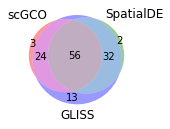

In [5]:
gsets = load_merfish_result(ddir, alpha= alpha)
print('GLISS rejects: {} genes'.format(len(ours)))
gsets['GLISS'] = set(ours)
# plot_custom_venn(gsets, fdir=None, figsize = (2.5,2.5))
fig, ax = plt.subplots(1, 1, figsize=(2,2))
vd = plot_venn3(gsets, ax)
vd.get_label_by_id("001").set_x(-0.05)
vd.get_label_by_id("011").set_x(0.4)
vd.get_label_by_id("101").set_x(-0.45)
plt.show()

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


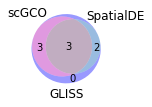

In [6]:
neg_sets = {}
for met in gsets:
    gset = gsets[met]
    rej = pd.Series([False] * df_res.shape[0], index=df_res.geneID)
    rej[gsets[met]] = True
    df_res['rej_{}'.format(met)] = rej
    ndf = df_res.loc[df_res['negative']]
    neg_sets[met] = set(ndf.loc[ndf['rej_{}'.format(met)]]['geneID'])
df_res.loc[df_res['negative']]
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5))
vd = plot_venn3(neg_sets, ax)
vd.get_label_by_id("001").set_y(-0.5)
vd.get_label_by_id("001").set_x(0.10)
vd.get_label_by_id("011").set_x(0.48)
vd.get_label_by_id("101").set_x(-0.45)
plt.show()

In [7]:
df = df_res.sort_values(by=['pvalue', 'rej_SpatialDE'], ascending=[True, False])
rej_cumsum = np.cumsum(df['rej_GLISS'])
df['rej_frac_SpatialDE'] = np.cumsum(df['rej_SpatialDE']) / rej_cumsum
df['rej_frac_scGCO'] = np.cumsum(df['rej_scGCO']) / rej_cumsum
display(df.head())
display(df.tail())

,pvalue,reject,geneID,negative,rej_scGCO,rej_SpatialDE,rej_GLISS,rej_frac_SpatialDE,rej_frac_scGCO
geneID,,,,,,,,,
AFAP1,0.0001,True,AFAP1,False,True,True,True,1.0,1.000000
AFF4,0.0001,True,AFF4,False,True,True,True,1.0,1.000000
AGAP1,0.0001,True,AGAP1,False,False,True,True,1.0,0.666667
AHDC1,0.0001,True,AHDC1,False,False,True,True,1.0,0.500000
ALPK2,0.0001,True,ALPK2,False,True,True,True,1.0,0.600000


,pvalue,reject,geneID,negative,rej_scGCO,rej_SpatialDE,rej_GLISS,rej_frac_SpatialDE,rej_frac_scGCO
geneID,,,,,,,,,
XDH,0.107789,False,XDH,False,False,False,False,0.728,0.672
Blank-3,0.170483,False,Blank-3,True,False,False,False,0.728,0.672
CRTAP,0.273273,False,CRTAP,False,False,False,False,0.728,0.672
TSTD2,0.372263,False,TSTD2,False,False,False,False,0.728,0.672
UMPS,0.857314,False,UMPS,False,False,False,False,0.728,0.672


Index(['Blank-6', 'Blank-4', 'Blank-8', 'Blank-1', 'Blank-5', 'Blank-9',
       'Blank-10', 'Blank-2', 'Blank-7', 'Blank-3'],
      dtype='object', name='geneID')


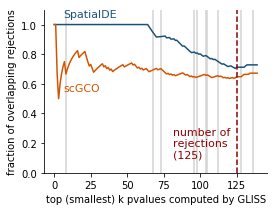

In [8]:
plot_blank = True
thres_col = 'darkred'
col1 = '#1A5276'
col2 = '#D35400'
fontsize=11
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
cols =  df.index
blank_ids = cols[cols.str.startswith('Blank')]
print(blank_ids)
if plot_blank:
    for bid in blank_ids:
        # get the index of the id
        bid_idx = df.index.get_loc(bid)
        # print('{}: {}'.format(bid, df.index.get_loc(bid)))
        ax.axvline(x=bid_idx, color='lightgrey', linestyle='-')
        
df.reset_index(drop=True)['rej_frac_SpatialDE'].plot(ax=ax, color=col1)
ax.text(6, 1.05, 'SpatialDE', color=col1, fontsize=fontsize)

df.reset_index(drop=True)['rej_frac_scGCO'].plot(ax=ax, color=col2)
ax.text(6, 0.55, 'scGCO', color=col2, fontsize=fontsize)
ax.set_ylim(0, 1.1)

ax.set_xlabel('top (smallest) k pvalues computed by GLISS')

ax.set_ylabel('fraction of overlapping rejections')

rej_pos = np.sum(df['rej_GLISS'])
ax.axvline(x=rej_pos, color=thres_col, linestyle='--')
ax.text(rej_pos*0.65, 0.1,
        'number of \nrejections\n({})'.format(rej_pos),
         color=thres_col, fontsize=fontsize)
plt.show()

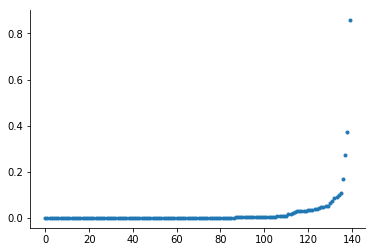

In [10]:
df.reset_index(drop=True)['pvalue'].plot(style='.')

# Plot the Processed Data

raw data dim: (1056, 140)


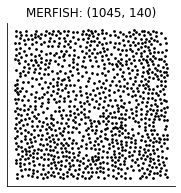

In [7]:
fdir = '/scratch/PI/sabatti/spatial_subplots/'
plot_all('MERFISH', plot_type='coord')
# plot_all('MERFISH', plot_type='venn', fdir=fdir)

Number of blank ids: 10
65 out of 71 strongly rejected by SpatialDE
50 out of 71 strongly rejected by scGCO


,pvalue,reject,geneID,negative,rej_scGCO,rej_SpatialDE,rej_GLISS
geneID,,,,,,,
LUZP1,0.0001,True,LUZP1,False,True,True,True
AGO3,0.0001,True,AGO3,False,False,False,True
CNR2,0.0001,True,CNR2,False,True,False,True
MYH10,0.0001,True,MYH10,False,True,True,True
AGAP1,0.0001,True,AGAP1,False,False,True,True
AMOTL1,0.0001,True,AMOTL1,False,True,True,True
KIF13B,0.0001,True,KIF13B,False,False,True,True
NHSL2,0.0001,True,NHSL2,False,True,True,True
PRPF8,0.0001,True,PRPF8,False,False,True,True


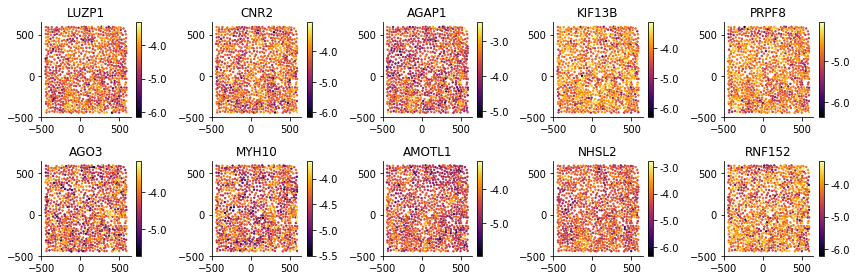

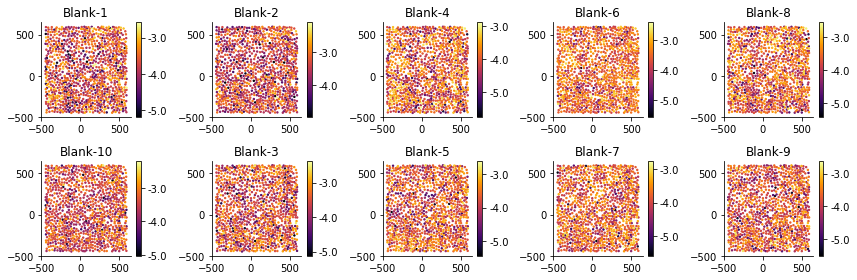

In [96]:
from plot_utils import plot_scatter_continuous
data_dir = '../data/'
f_pfx = 'MERFISH'
fn_coord = data_dir + '{}_coord.csv'.format(f_pfx)
fn_expr = data_dir + '{}_expr.csv'.format(f_pfx)
data = pd.read_csv(fn_expr, index_col=0)
coor = pd.read_csv(fn_coord, index_col=0)

cols =  data.columns
blank_ids = cols[cols.str.startswith('Blank')]
print('Number of blank ids: {}'.format(len(blank_ids)))
min_pval = min(df_res['pvalue'])
most_rej = df_res.loc[df_res['pvalue']==min_pval] # .sort_values('pvalue_ours').head(80)
print('{} out of {} strongly rejected by SpatialDE'.format(
    np.sum(most_rej['rej_SpatialDE']), most_rej.shape[0]))
print('{} out of {} strongly rejected by scGCO'.format(
    np.sum(most_rej['rej_scGCO']), most_rej.shape[0]))
np.random.seed(10)
use_rej = most_rej.sample(10)
display(use_rej)
strong_rej_ids = list(use_rej['geneID'])

# plot_multiple_scatter_continuous(coor, data[blank_ids])
for plot_ids in [strong_rej_ids, blank_ids]:
    fig, axes = plt.subplots(2, 5, figsize = (12, 4))
    for i, col in enumerate(plot_ids):
        ax = axes[i % 2][i // 2]
        plot_scatter_continuous(coor, data[col], ax, logscale=False, ms=2)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()

In [95]:
df_res.loc[df_res['negative']]

,pvalue,reject,geneID,negative,rej_scGCO,rej_SpatialDE,rej_GLISS
geneID,,,,,,,
Blank-1,0.003200,True,Blank-1,True,True,True,True
Blank-10,0.005000,True,Blank-10,True,True,False,True
Blank-2,0.018898,True,Blank-2,True,True,False,True
Blank-3,0.170483,False,Blank-3,True,False,False,False
Blank-4,0.000100,True,Blank-4,True,True,False,True
Blank-5,0.003700,True,Blank-5,True,True,True,True
Blank-6,0.000100,True,Blank-6,True,False,True,True
Blank-7,0.050995,False,Blank-7,True,False,False,False
Blank-8,0.000400,True,Blank-8,True,True,True,True
